# MODELO XGBOOST PARA ALGORTIMO DE CALIFICACIÓN TRANSFORMADORES DE CORRIENTE

## Paquetes


In [1]:
# Librerias
# Cargar librerias
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sb
 
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

from sklearn.model_selection import StratifiedKFold
# librerías Árboles de Decisión
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont

# librerías Gaussian Naive Bayes
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import make_scorer

## CARGA DE DATOS


Aqui se cargaran los datos que fueron usados para entrenar los modelos tanto para el modelo instanciado como por el encontrado por grid search. En caso de encontrarse errores, este modelo debe ser entrenado con estos datos y sumando a esto, los datos que se creen con la metodología adecuada. Esto se hizo en excel


In [3]:
df_mr3=pd.read_excel('./TrainDef/MRCAL3_TEST1.xlsx').dropna()
df_mr=pd.read_excel('./TrainDef/MR_TEST.xlsx').dropna()
df_v1_r5=pd.read_excel('./TrainDef/DataSetR5.xlsx')
c1_r5=pd.read_excel('./TrainDef/CasosCalificacionesNoFabricante.xlsx',sheet_name='TEST').dropna()
mr_unidos=pd.concat([df_mr,df_mr3],axis=0)
df_total=pd.concat([c1_r5,mr_unidos],axis=0)

In [4]:
#Datos fallidos de entrenamiento
y_aux=df_total['CHANGED_calificacion_del_equipo'] 
X_aux=df_total.drop(['CHANGED_calificacion_del_equipo'],axis=1)

In [5]:
f0_l1=pd.read_excel('./TrainDef/FabricanteCalificador.xlsx').dropna()
y_aux_f0l1=f0_l1['CHANGED_calificacion_del_equipo']
X_aux_f0l1=f0_l1.drop(['CHANGED_calificacion_del_equipo'],axis=1)

In [6]:
#Mezclar datos
df_sai_copy4=df_v1_r5.sample(frac=1).reset_index(drop=True)

X = df_sai_copy4.drop(['CHANGED_calificacion_del_equipo'], axis=1)

#CARACTERÍSTICA OBJETIVO
y = df_sai_copy4['CHANGED_calificacion_del_equipo'] 

#X = np.array(X) #Para arboles, esto no es necesario aun.
#y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.05, #50% datos de entrenamiento, 50% prueba
                                                    stratify = y,
                                                    random_state = 25)

In [7]:
#Add new data
X_train_c1=np.array(X_train)
X_aux_c1=np.array(X_aux)
print(X_train_c1.shape,X_aux_c1.shape)
X_train_c2=np.concatenate((X_train_c1, X_aux_c1), axis=0)
#X_train_c2=np.array(X_aux)
print(X_train_c2.shape)

y_train_c1=np.array(y_train)
y_aux_c1=np.array(y_aux)
print(y_train_c1.shape,y_aux_c1.shape)
y_train_c2=np.concatenate((y_train_c1, y_aux_c1), axis=0)
#y_train_c2=np.array(y_aux)
print(y_train_c2.shape)

(4431, 17) (2038118, 17)
(2042549, 17)
(4431,) (2038118,)
(2042549,)


In [8]:
#Add new data ONLY RUN ONES, RUN UPPER Before
X_train_c1=np.array(X_train_c2)
X_aux_c1=np.array(X_aux_f0l1)
print(X_train_c1.shape,X_aux_c1.shape)
X_train_c2=np.concatenate((X_train_c1, X_aux_c1), axis=0)
print(X_train_c2.shape)

y_train_c1=np.array(y_train_c2)
y_aux_c1=np.array(y_aux_f0l1)
print(y_train_c1.shape,y_aux_c1.shape)
y_train_c2=np.concatenate((y_train_c1, y_aux_c1), axis=0)
print(y_train_c2.shape)

(2042549, 17) (827150, 17)
(2869699, 17)
(2042549,) (827150,)
(2869699,)


In [9]:
df_x_train_c2=pd.DataFrame(X_train_c2,columns=['capacitancia_total',
       'factor_de_potencia_10kv_ctotal', 'factor_de_potencia_2.5kv_ctotal',
       'medida_resistencia_aislamiento_nucleo_1_ultimo',
       'medida_resistencia_aislamiento_nucleo_2_ultimo',
       'medida_resistencia_aislamiento_nucleo_3_ultimo',
       'medida_resistencia_aislamiento_nucleo_4_ultimo',
       'medida_resistencia_aislamiento_nucleo_5_ultimo',
       'medida_resistencia_aislamiento_nucleo_6_ultimo',
       'severidad_por_termografia',"Fabricante", 'CHANGED_estado_cajetin',
       'CHANGED_estado_porcelana', 'CHANGED_fuga_de_aceite',
       'CHANGED_inspeccion_diafragma', 'CHANGED_inspeccion_visual_general',
       'CHANGED_nivel_de_aceite'])

df_x_test_c2=pd.DataFrame(X_test,columns=['capacitancia_total',
       'factor_de_potencia_10kv_ctotal', 'factor_de_potencia_2.5kv_ctotal',
       'medida_resistencia_aislamiento_nucleo_1_ultimo',
       'medida_resistencia_aislamiento_nucleo_2_ultimo',
       'medida_resistencia_aislamiento_nucleo_3_ultimo',
       'medida_resistencia_aislamiento_nucleo_4_ultimo',
       'medida_resistencia_aislamiento_nucleo_5_ultimo',
       'medida_resistencia_aislamiento_nucleo_6_ultimo',
       'severidad_por_termografia',"Fabricante", 'CHANGED_estado_cajetin',
       'CHANGED_estado_porcelana', 'CHANGED_fuga_de_aceite',
       'CHANGED_inspeccion_diafragma', 'CHANGED_inspeccion_visual_general',
       'CHANGED_nivel_de_aceite'])

Todo este proceso se realizó de esta manera debido al contexto de investigación y una busqueda insesante del resultado, por lo que perfectamente se puede escribir de manera mas optima y ordenada toda esta tuberia.

## MODELO XGBOOST 
TENER CUIDADO PUESTO QUE MUCHAS COSAS ESTAN EJECUTADAS POR GPU POR LO QUE PUEDEN FALLAR

In [9]:
from xgboost import XGBClassifier

#xgbc_grid=XGBClassifier()
xgbc_prueba=XGBClassifier(base_score=0.5,max_depth=50,
              booster='gbtree', 
              learning_rate=0.9,
              missing=1,
              n_estimators=40, 
              nthread=None,
              min_split_loss=1,
              objective='multi:softprob',
              min_child_weight=0,
              subsample=0.4,
              colsample_bylevel=0.5,
              colsample_bynode=1,
              max_cat_threshold=5,   
              verbosity=1,tree_method='gpu_hist') 

In [10]:
xgbc_prueba.fit(df_x_train_c2, y_train_c2)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=0.5, colsample_bynode=1, colsample_bytree=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.9, max_bin=None,
              max_cat_threshold=5, max_cat_to_onehot=None, max_delta_step=None,
              max_depth=50, max_leaves=None, min_child_weight=0,
              min_split_loss=1, missing=1, monotone_constraints=None,
              n_estimators=40, n_jobs=None, nthread=None,
              num_parallel_tree=None, ...)

Con el codigo de abajo, podemos guardar el modelo anteriormente ajustado con el nombre que deseemos. Se guardará en la carpeta donde esté alojado esta notebook

In [11]:
xgbc_prueba.save_model("nombre_modelo.txt")

Con el codigo de abajo logramos cargar el modelo previamente guardado.

In [12]:
#Load model of 1 variable
from xgboost import XGBClassifier
xgbc_prueba = XGBClassifier()
xgbc_prueba.load_model("nombre_modelo.txt")

### METRICAS

In [13]:
y_pred = xgbc_prueba.predict(df_x_test_c2)
print('Exactitud de los datos de entrenamiento: {:.2f}'
     .format(xgbc_prueba.score(df_x_train_c2, y_train_c2)))
print('Exactitud de los datos de prueba {:.2f}'
     .format(xgbc_prueba.score(df_x_test_c2, y_test)))

Exactitud de los datos de entrenamiento: 1.00
Exactitud de los datos de prueba 1.00


In [14]:
decoded_y_test = y_test
decoded_predictions = xgbc_prueba.predict(df_x_test_c2)
print(f'Reporte de clasificación:')
print(classification_report(decoded_y_test,
                            decoded_predictions))

Reporte de clasificación:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        64
           1       1.00      1.00      1.00        66
           2       1.00      1.00      1.00        59
           3       1.00      1.00      1.00        45

    accuracy                           1.00       234
   macro avg       1.00      1.00      1.00       234
weighted avg       1.00      1.00      1.00       234



### VALIDACION CRUZADA

In [15]:
scores = cross_val_score(xgbc_prueba, df_x_train_c2, y_train_c2, cv=3,n_jobs=5)
print("Mean cross-validation score: %.2f" % scores.mean())

kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(xgbc_prueba, df_x_train_c2, y_train_c2, cv=kfold,n_jobs=5)

Mean cross-validation score: 0.98


In [16]:
kf_cv_scores 

array([0.99924034, 0.99915671, 0.9991811 , 0.99935882, 0.99923337,
       0.99924382, 0.99929609, 0.99919155, 0.99932746, 0.99917413])

En algunos entornos, esta funcion Plot_confusion_matrix suele fallar al estar "descontinuada". Se puede reemplazar perfectamente con la libreria actual.

### Matriz de confusión

c:\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


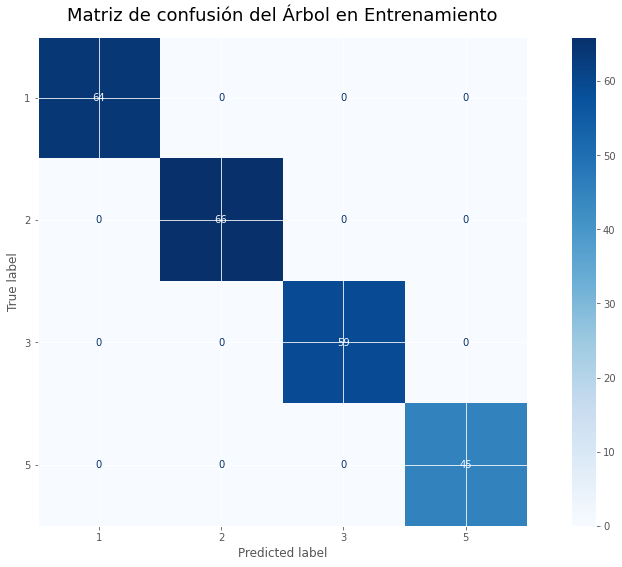

In [17]:
#Matriz de confunsion
disp = plot_confusion_matrix(xgbc_prueba, df_x_test_c2, y_test,
                                 display_labels=[1,2,3,5],
                                 cmap=plt.cm.Blues,
                                 normalize=None)
disp.ax_.set_title('Matriz de confusión del Árbol en Entrenamiento', y=1.02, size=18)

plt.show()

### Observaciones erroneas

Con este codigo podemos ver en cuales posibles observaciones el modelo tuvo errores, ademas de ver que tanta confianza tuvo al momento de tomar las decisiones, siendo este numero fundamental a la hora de determinar que tanto el modelo aprendió en esos casos

In [18]:
#Añadir las calificaciones reales
X_test_c1=df_x_test_c2.copy()
X_test_c1['CALIFICACION_VERDADERA']=np.array(y_test)

df_predict=pd.DataFrame(columns=('capacitancia_total',
       'factor_de_potencia_10kv_ctotal', 'factor_de_potencia_2.5kv_ctotal',
       'medida_resistencia_aislamiento_nucleo_1_ultimo',
       'medida_resistencia_aislamiento_nucleo_2_ultimo',
       'medida_resistencia_aislamiento_nucleo_3_ultimo',
       'medida_resistencia_aislamiento_nucleo_4_ultimo',
       'medida_resistencia_aislamiento_nucleo_5_ultimo',
       'medida_resistencia_aislamiento_nucleo_6_ultimo',
       'severidad_por_termografia',"Fabricante", 'CHANGED_estado_cajetin',
       'CHANGED_estado_porcelana', 'CHANGED_fuga_de_aceite',
       'CHANGED_inspeccion_diafragma', 'CHANGED_inspeccion_visual_general',
       'CHANGED_nivel_de_aceite','CALIFICACION_VERDADERA','PREDICCION','%CONFIANZA'))
#Confianza con los datos de prueba.
i=0
#for index, row in X_test_c1.iterrows():
    #y_p1_predict=clf.predict(row)
    #print(y_p1_predict[0])
    #y_proba = clf.predict_proba(row)
    #print(y_proba)
    #df_predict.loc[i]=row
    #df_predict.at[i,'PREDICCION']=y_p1_predict[0]
    #df_predict.at[i,'%CONFIANZA']=np.round(np.max(y_proba), 2)*100
    #i+=1
#Añadir las calificaciones reales
for index, row in X_test_c1.iterrows():
    #y_p1_predict=xgbc.predict(row)
    #print(y_p1_predict[0])
    y_proba = xgbc_prueba.predict_proba(X_test)
    #print(y_proba)
    df_predict.loc[i]=row
    #df_predict.at[i,'PREDICCION']=y_p1_predict[0]
    df_predict.at[i,'%CONFIANZA']=np.round(np.max(y_proba[i]), 2)*100
    i+=1
y_p1_predict=xgbc_prueba.predict(df_x_test_c2) 
#df_predict['CALIFICACION_VERDADERA']=y_test
df_predict['PREDICCION']=y_p1_predict
df_predict
df_predict.sort_values(by='%CONFIANZA')

,capacitancia_total,factor_de_potencia_10kv_ctotal,factor_de_potencia_2.5kv_ctotal,medida_resistencia_aislamiento_nucleo_1_ultimo,medida_resistencia_aislamiento_nucleo_2_ultimo,medida_resistencia_aislamiento_nucleo_3_ultimo,medida_resistencia_aislamiento_nucleo_4_ultimo,medida_resistencia_aislamiento_nucleo_5_ultimo,medida_resistencia_aislamiento_nucleo_6_ultimo,severidad_por_termografia,Fabricante,CHANGED_estado_cajetin,CHANGED_estado_porcelana,CHANGED_fuga_de_aceite,CHANGED_inspeccion_diafragma,CHANGED_inspeccion_visual_general,CHANGED_nivel_de_aceite,CALIFICACION_VERDADERA,PREDICCION,%CONFIANZA
82,-0.033808,0.394445,-0.562031,3198.0,4058.0,10432.0,6694.0,7884.0,147.0,5.0,4.0,5.0,5.0,5.0,5.0,5.0,5.0,1.0,1,63.999999
48,0.007037,0.003253,0.318092,11347.0,11399.0,4917.0,10452.0,13493.0,317.0,5.0,3.0,5.0,5.0,5.0,5.0,5.0,5.0,2.0,2,88.000000
66,-0.036627,0.886688,0.299405,8813.0,17783.0,12440.0,13021.0,-8691.0,-8691.0,5.0,1.0,5.0,3.0,5.0,5.0,5.0,5.0,2.0,2,88.999999
146,-0.017451,0.267489,0.023317,7218.0,14491.0,13757.0,2618.0,-8691.0,172.0,3.0,0.0,5.0,5.0,5.0,5.0,5.0,5.0,1.0,1,88.999999
212,0.032380,0.014704,0.384017,5004.0,2902.0,2267.0,9771.0,186.0,14069.0,5.0,2.0,5.0,5.0,5.0,5.0,5.0,5.0,1.0,1,91.000003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,-0.001669,-0.157258,-0.207692,42800.0,48000.0,42300.0,47100.0,43900.0,53900.0,5.0,3.0,5.0,5.0,5.0,5.0,5.0,5.0,3.0,3,100.000000
96,-0.005503,0.515152,-0.038462,169000.0,155000.0,168000.0,150000.0,121000.0,116000.0,5.0,4.0,5.0,5.0,5.0,5.0,5.0,5.0,3.0,3,100.000000
98,0.029913,0.884274,2.337492,11239.0,11741.0,6368.0,-8691.0,-8691.0,-8691.0,5.0,3.0,5.0,5.0,5.0,5.0,5.0,5.0,0.0,0,100.000000
83,0.005735,0.178261,0.000000,40200.0,42200.0,37400.0,40200.0,-8691.0,-8691.0,5.0,3.0,5.0,5.0,5.0,1.0,5.0,5.0,0.0,0,100.000000


### PRUEBAS UNITARIAS

Con estas pruebas junto a un experto o con reglas en mano, se pueden probar casos de manera individual, de manera aleatoria o con cierta rigurosidad, con el fin de determinar posibles casos potenciales donde la capacidad del modelo no llega y pueda poner en riesgo las labores de mantenimiento.

In [19]:
import random
labels=[1,2,3,5]

#Prueba unitaria
X_test_c1=np.array(X_test)

C=round((random.random()*(0.1+0.1)-0.1)*1,4)
F10=round(random.random()*(2.5+1)-1,3)
F25=round(random.random()*(2.5+1)-1,3)
#F10=0.868634432
#F25=0.706416317
C2=round((random.random()*(0.045-0.04)+0.04),4)
C3=round((random.random()*(0.04-0.035)+0.035),4)
N1=random.randint(0,1300)
N2=random.randint(0,1300)
N3=random.randint(0,1300)
N4=random.randint(0,1300)
N5=random.randint(0,1300)
N6=random.randint(0,1300)
N1=27976
N2=4773
N3=28595
N4=29515
N5=-8691
N6=-8691
C=-0.03
print("Capacitancia: "+str(C)+", Factor de potencia 10kv: "+ str(F10) + ", Factor de potencia 2.5k: "+str(F25))
print("Resistencia Nucleo 1: "+str(N1),"Resistencia Nucleo 2: "+str(N2),"Resistencia Nucleo 3 "+str(N3),"Resistencia Nucleo 4: "+str(N4),"Resistencia Nucleo 5: "+str(N5),"Resistencia Nucleo 6: "+str(N6))
F=random.randint(0,4)
F=3
print("Fabricante: "+str(F))
unit_test=np.array([[C,   #capacitancia_total
                     F10,  #factor_de_potencia_10kv_ctotal
                     F25,   #factor_de_potencia_2.5kv_ctotal
                     N1, #medida_resistencia_aislamiento_nucleo_1_ultimo
                     N2, #medida_resistencia_aislamiento_nucleo_2_ultimo
                     N3, #medida_resistencia_aislamiento_nucleo_3_ultimo
                     N4,    #medida_resistencia_aislamiento_nucleo_4_ultimo
                     N5,    #medida_resistencia_aislamiento_nucleo_5_ultimo
                     N6,    #medida_esistencia_aislamiento_nucleo_6_ultimo
                     5,     #severidad_por_termografia	
                     F,     #Fabricante	
                     5,     #CHANGED_estado_cajetin
                     5,     #CHANGED_estado_porcelana	
                     5,     #CHANGED_fuga_de_aceite	
                     5,     #CHANGED_inspeccion_diafragma	
                     5,     #CHANGED_inspeccion_visual_general
                     5      #CHANGED_nivel_de_aceite
                     ],
                    [0.008,1.18,1.08151,5000,100000,550,520,-1,-1,5,3,5,5,5,5,5,5]])
unit_test1=np.concatenate((X_test_c1,unit_test),axis=0)
p=xgbc_prueba.predict(unit_test1)
prob=xgbc_prueba.predict_proba(unit_test1)
print(f"Calificacion: "+ str(labels[p[len(unit_test1)-2]]) + ", Con una confianza de "+ str(np.max(prob[len(unit_test1)-2])*100) + "%.")
print("Segundo Label mas confiable: " + str(labels[list(prob[len(unit_test1)-2]).index(sorted(prob[len(unit_test1)-2])[2])]
) + " Con una confianza del " + str(sorted(prob[len(unit_test1)-2])[2]*100) + "%")

Capacitancia: -0.03, Factor de potencia 10kv: 0.518, Factor de potencia 2.5k: 2.169
Resistencia Nucleo 1: 27976 Resistencia Nucleo 2: 4773 Resistencia Nucleo 3 28595 Resistencia Nucleo 4: 29515 Resistencia Nucleo 5: -8691 Resistencia Nucleo 6: -8691
Fabricante: 3
Calificacion: 1, Con una confianza de 99.99958276748657%.
Segundo Label mas confiable: 2 Con una confianza del 0.0002814237177517498%


### Importancia de variables por impureza de nodos

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

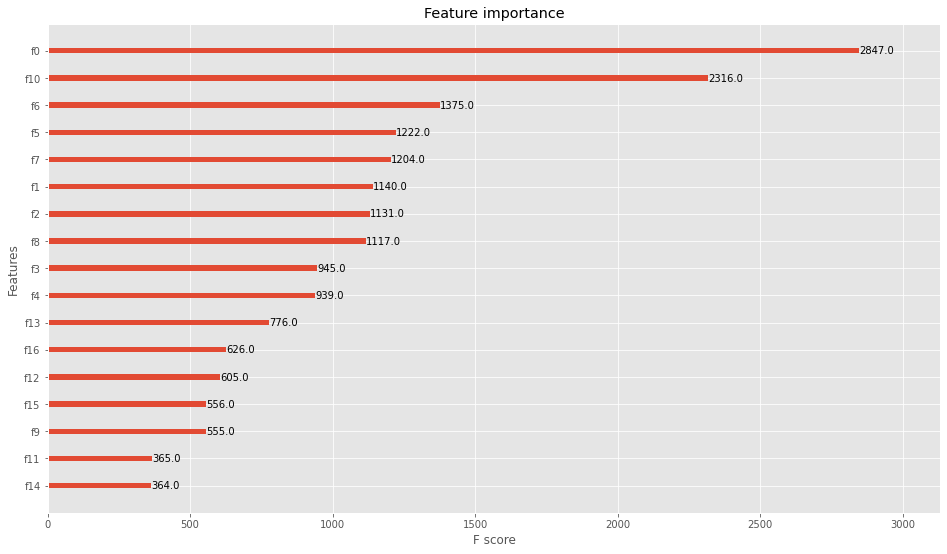

In [20]:
from xgboost import plot_importance
plot_importance(xgbc_prueba)

### Importancia de variables por permutación.

In [21]:
from sklearn.inspection import permutation_importance
import multiprocessing 

In [22]:
importancia_predictores = pd.DataFrame(
                            {'predictor': df_x_train_c2.columns,
                             'importancia': xgbc_prueba.feature_importances_}
                            )
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores.sort_values('importancia', ascending=False)

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
11,CHANGED_estado_cajetin,0.098834
14,CHANGED_inspeccion_diafragma,0.091386
3,medida_resistencia_aislamiento_nucleo_1_ultimo,0.083064
2,factor_de_potencia_2.5kv_ctotal,0.082062
1,factor_de_potencia_10kv_ctotal,0.080226
4,medida_resistencia_aislamiento_nucleo_2_ultimo,0.077140
0,capacitancia_total,0.067704
13,CHANGED_fuga_de_aceite,0.066704
16,CHANGED_nivel_de_aceite,0.065066
12,CHANGED_estado_porcelana,0.060669


In [23]:
importancia = permutation_importance(
                estimator    = xgbc_prueba,
                X            = df_x_train_c2,
                y            = y_train_c2,
                n_repeats    = 5,
                scoring      = 'neg_root_mean_squared_error',
                n_jobs       = multiprocessing.cpu_count() - 1,
                random_state = 123
             )

# Se almacenan los resultados (media y desviación) en un dataframe
df_importancia = pd.DataFrame(
                    {k: importancia[k] for k in ['importances_mean', 'importances_std']}
                 )
df_importancia['feature'] = X_train.columns
df_importancia.sort_values('importances_mean', ascending=False)

,importances_mean,importances_std,feature
0,0.521998,0.000120,capacitancia_total
1,0.432712,0.000411,factor_de_potencia_10kv_ctotal
2,0.427155,0.000322,factor_de_potencia_2.5kv_ctotal
6,0.330531,0.000391,medida_resistencia_aislamiento_nucleo_4_ultimo
10,0.304776,0.000237,Fabricante
5,0.296280,0.000329,medida_resistencia_aislamiento_nucleo_3_ultimo
3,0.292250,0.000639,medida_resistencia_aislamiento_nucleo_1_ultimo
4,0.278754,0.000360,medida_resistencia_aislamiento_nucleo_2_ultimo
7,0.239762,0.000318,medida_resistencia_aislamiento_nucleo_5_ultimo
13,0.237759,0.000353,CHANGED_fuga_de_aceite


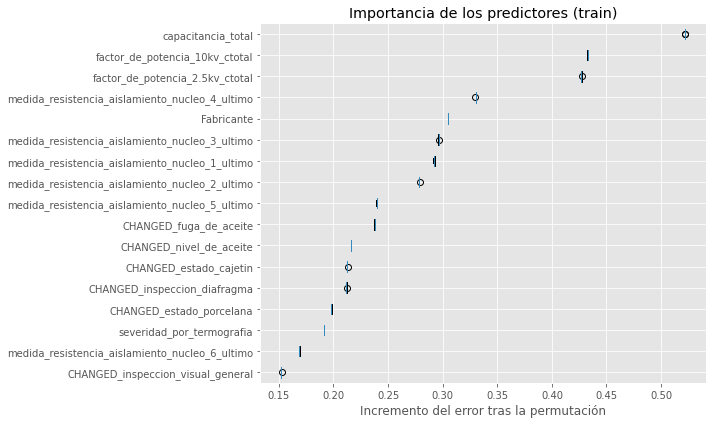

In [24]:
# Gráfico
fig, ax = plt.subplots(figsize=(10, 6))

sorted_idx = importancia.importances_mean.argsort()
ax.boxplot(
        importancia.importances[sorted_idx].T,
        vert   = False,
        labels =df_x_train_c2.columns[sorted_idx]
)
ax.set_title('Importancia de los predictores (train)')
ax.set_xlabel('Incremento del error tras la permutación')
fig.tight_layout();

## XGBOOST GRID SEARCH

In [25]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# Encontrar los mejores hiperparametros para arboles de decision
dtc = XGBClassifier(tree_method='gpu_hist')
cv=7        #Cross validation realizado cv veces.
param_grid = {'learning_rate': [0.4,0.5,0.6,0.8,0.9], 
                'max_depth':[21,30,40,50,70,100,150], 
                'n_estimators': [10,20,40,50,100,200,300]}  


#Parametros a probar
grid_search = GridSearchCV(dtc, param_grid=param_grid, cv=cv)
grid_search.fit(df_x_train_c2, y_train_c2)

KeyboardInterrupt: 

In [ ]:
best_estimator = grid_search.best_estimator_

In [ ]:
grid_search.best_params_

In [ ]:
#If model is well.
best_estimator.save_model("nombre_modelo_grid.txt")

Aqui se cargó el mejor modelo hasta la fecha

In [10]:
#Load model of 1 variable
from xgboost import XGBClassifier
best_estimator = XGBClassifier()
best_estimator.load_model("xgbc_params_1_1_best_params.txt")

### REVISIÓN DE PREDICCIONES

In [11]:
#Añadir las calificaciones reales
X_test_c1=df_x_test_c2.copy()
X_test_c1['CALIFICACION_VERDADERA']=np.array(y_test)

df_predict=pd.DataFrame(columns=('capacitancia_total',
       'factor_de_potencia_10kv_ctotal', 'factor_de_potencia_2.5kv_ctotal',
       'medida_resistencia_aislamiento_nucleo_1_ultimo',
       'medida_resistencia_aislamiento_nucleo_2_ultimo',
       'medida_resistencia_aislamiento_nucleo_3_ultimo',
       'medida_resistencia_aislamiento_nucleo_4_ultimo',
       'medida_resistencia_aislamiento_nucleo_5_ultimo',
       'medida_resistencia_aislamiento_nucleo_6_ultimo',
       'severidad_por_termografia',"Fabricante", 'CHANGED_estado_cajetin',
       'CHANGED_estado_porcelana', 'CHANGED_fuga_de_aceite',
       'CHANGED_inspeccion_diafragma', 'CHANGED_inspeccion_visual_general',
       'CHANGED_nivel_de_aceite','CALIFICACION_VERDADERA','PREDICCION','%CONFIANZA'))
#Confianza con los datos de prueba.
i=0
#for index, row in X_test_c1.iterrows():
    #y_p1_predict=clf.predict(row)
    #print(y_p1_predict[0])
    #y_proba = clf.predict_proba(row)
    #print(y_proba)
    #df_predict.loc[i]=row
    #df_predict.at[i,'PREDICCION']=y_p1_predict[0]
    #df_predict.at[i,'%CONFIANZA']=np.round(np.max(y_proba), 2)*100
    #i+=1
#Añadir las calificaciones reales
for index, row in X_test_c1.iterrows():
    #y_p1_predict=xgbc.predict(row)
    #print(y_p1_predict[0])
    y_proba = best_estimator.predict_proba(X_test)
    #print(y_proba)
    df_predict.loc[i]=row
    #df_predict.at[i,'PREDICCION']=y_p1_predict[0]
    df_predict.at[i,'%CONFIANZA']=np.round(np.max(y_proba[i]), 2)*100
    i+=1
y_p1_predict=best_estimator.predict(df_x_test_c2) 
#df_predict['CALIFICACION_VERDADERA']=y_test
df_predict['PREDICCION']=y_p1_predict
df_predict

,capacitancia_total,factor_de_potencia_10kv_ctotal,factor_de_potencia_2.5kv_ctotal,medida_resistencia_aislamiento_nucleo_1_ultimo,medida_resistencia_aislamiento_nucleo_2_ultimo,medida_resistencia_aislamiento_nucleo_3_ultimo,medida_resistencia_aislamiento_nucleo_4_ultimo,medida_resistencia_aislamiento_nucleo_5_ultimo,medida_resistencia_aislamiento_nucleo_6_ultimo,severidad_por_termografia,Fabricante,CHANGED_estado_cajetin,CHANGED_estado_porcelana,CHANGED_fuga_de_aceite,CHANGED_inspeccion_diafragma,CHANGED_inspeccion_visual_general,CHANGED_nivel_de_aceite,CALIFICACION_VERDADERA,PREDICCION,%CONFIANZA
0,0.028764,-0.626176,-1.000000,8368.0,2039.0,8841.0,12813.0,4467.0,12350.0,5.0,4.0,5.0,1.0,5.0,5.0,5.0,5.0,1.0,1,100.000000
1,0.022859,1.265770,-1.000000,1922.0,12426.0,839.0,6460.0,11926.0,6453.0,5.0,4.0,5.0,5.0,5.0,5.0,5.0,5.0,2.0,2,100.000000
2,-0.017063,-0.834431,0.400828,25190.0,36944.0,45075.0,13946.0,20014.0,27773.0,5.0,3.0,5.0,5.0,5.0,5.0,5.0,5.0,3.0,3,100.000000
3,0.038771,0.362664,0.062140,1024.0,3491.0,4729.0,4488.0,-8691.0,-8691.0,5.0,1.0,5.0,5.0,3.0,5.0,5.0,3.0,1.0,1,100.000000
4,-0.036779,1.460258,-0.674892,203.0,985.0,1732.0,1343.0,1323.0,281.0,3.0,2.0,5.0,3.0,5.0,5.0,5.0,5.0,2.0,2,99.000001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229,0.010575,0.272897,-0.872841,11170.0,25.0,7.0,4869.0,1812.0,576.0,5.0,4.0,5.0,5.0,5.0,5.0,5.0,5.0,0.0,0,100.000000
230,-0.018671,-0.037079,0.595206,23084.0,63.0,6728.0,20725.0,-8691.0,-8691.0,5.0,1.0,5.0,5.0,5.0,5.0,5.0,5.0,1.0,1,100.000000
231,-0.022513,1.166582,1.187780,13102.0,4965.0,7667.0,6129.0,14347.0,-8691.0,5.0,3.0,5.0,5.0,0.0,5.0,5.0,5.0,0.0,0,100.000000
232,0.030146,-1.000000,0.454483,10354.0,9828.0,10571.0,3618.0,28.0,17.0,5.0,0.0,5.0,5.0,5.0,5.0,5.0,5.0,0.0,0,100.000000


### METRICAS

In [12]:
y_pred = best_estimator.predict(X_test)
print('Exactitud de los datos de entrenamiento: {:.2f}'
     .format(best_estimator.score(df_x_train_c2, y_train_c2)))
print('Exactitud de los datos de prueba {:.2f}'
     .format(best_estimator.score(df_x_test_c2, y_test)))
     
decoded_y_test = y_test
decoded_predictions = best_estimator.predict(df_x_test_c2)
print(f'Reporte de clasificación:')
print(classification_report(decoded_y_test,
                            decoded_predictions))

Exactitud de los datos de entrenamiento: 1.00
Exactitud de los datos de prueba 1.00
Reporte de clasificación:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        64
           1       1.00      1.00      1.00        66
           2       1.00      1.00      1.00        59
           3       1.00      1.00      1.00        45

    accuracy                           1.00       234
   macro avg       1.00      1.00      1.00       234
weighted avg       1.00      1.00      1.00       234



#### MATRIZ DE CONFUSIÓN

c:\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


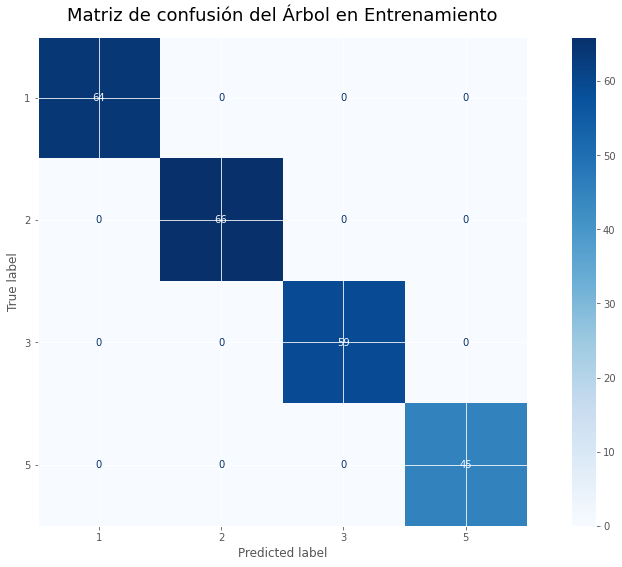

In [13]:
#Matriz de confunsión 
disp = plot_confusion_matrix(best_estimator, X_test, y_test,
                                 display_labels=[1,2,3,5],
                                 cmap=plt.cm.Blues,
                                 normalize=None)
disp.ax_.set_title('Matriz de confusión del Árbol en Entrenamiento', y=1.02, size=18)

plt.show()

#### IMPORTANCIA DE VARIABLES POR IMPUREZA DE NODOS

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

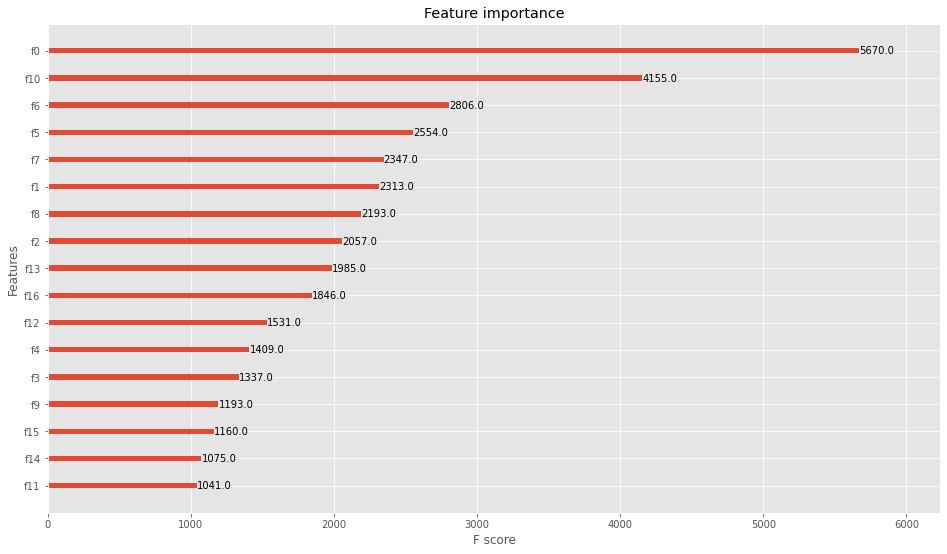

In [14]:
from xgboost import plot_importance
plot_importance(best_estimator)

#### CURVA ROC

In [15]:
from sklearn.preprocessing import label_binarize

In [16]:
# Binarizar la etiqueta
y = label_binarize(y, classes=[0, 1, 2,3])
# Establecer tipo
n_classes = y.shape[1]

# Entrene el modelo y prediga
random_state = np.random.RandomState(0)
n_samples, n_features = X.shape

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.05,random_state=0)

In [17]:
y_score = best_estimator.predict_proba(X_test)

C:\Users\luis\AppData\Local\Temp\ipykernel_12416\2959654853.py:30: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


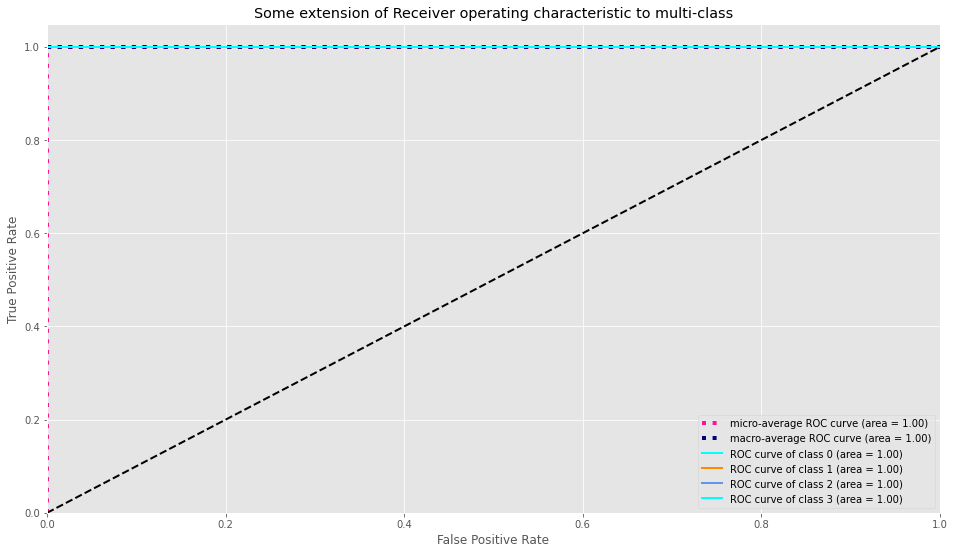

In [18]:
# Introducir las bibliotecas necesarias
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from scipy import interp


# Calcule la ROC de cada categoría
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Calcular la curva ROC y el área ROC de micropromedio (Método 2)
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Calcule la curva ROC macro-promedio y el área ROC (Método 1)
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
# Finally average it and compute AUC
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
lw=2
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

#### IMPORTANCIA DE VARIABLES POR PERMUTACIONES

In [19]:
importancia_predictores = pd.DataFrame(
                            {'predictor': df_x_train_c2.columns,
                             'importancia': best_estimator.feature_importances_}
                            )
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores.sort_values('importancia', ascending=False)

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
3,medida_resistencia_aislamiento_nucleo_1_ultimo,0.112205
2,factor_de_potencia_2.5kv_ctotal,0.108854
4,medida_resistencia_aislamiento_nucleo_2_ultimo,0.101027
1,factor_de_potencia_10kv_ctotal,0.098530
0,capacitancia_total,0.071194
14,CHANGED_inspeccion_diafragma,0.068858
11,CHANGED_estado_cajetin,0.068425
13,CHANGED_fuga_de_aceite,0.050250
12,CHANGED_estado_porcelana,0.049930
9,severidad_por_termografia,0.047612


In [21]:
from sklearn.inspection import permutation_importance
import multiprocessing 

In [22]:
importancia = permutation_importance(
                estimator    = best_estimator,
                X            = df_x_train_c2,
                y            = y_train_c2,
                n_repeats    = 5,
                scoring      = 'neg_root_mean_squared_error',
                n_jobs       = multiprocessing.cpu_count() - 1,
                random_state = 123
             )

# Se almacenan los resultados (media y desviación) en un dataframe
df_importancia = pd.DataFrame(
                    {k: importancia[k] for k in ['importances_mean', 'importances_std']}
                 )
df_importancia['feature'] = X_train.columns
df_importancia.sort_values('importances_mean', ascending=False)

,importances_mean,importances_std,feature
0,0.537474,0.000124,capacitancia_total
1,0.447946,0.000425,factor_de_potencia_10kv_ctotal
2,0.442361,0.000318,factor_de_potencia_2.5kv_ctotal
10,0.319828,0.000239,Fabricante
6,0.307817,0.000519,medida_resistencia_aislamiento_nucleo_4_ultimo
3,0.306963,0.000622,medida_resistencia_aislamiento_nucleo_1_ultimo
4,0.293448,0.000344,medida_resistencia_aislamiento_nucleo_2_ultimo
5,0.293105,0.000408,medida_resistencia_aislamiento_nucleo_3_ultimo
13,0.252228,0.000375,CHANGED_fuga_de_aceite
7,0.233090,0.000309,medida_resistencia_aislamiento_nucleo_5_ultimo


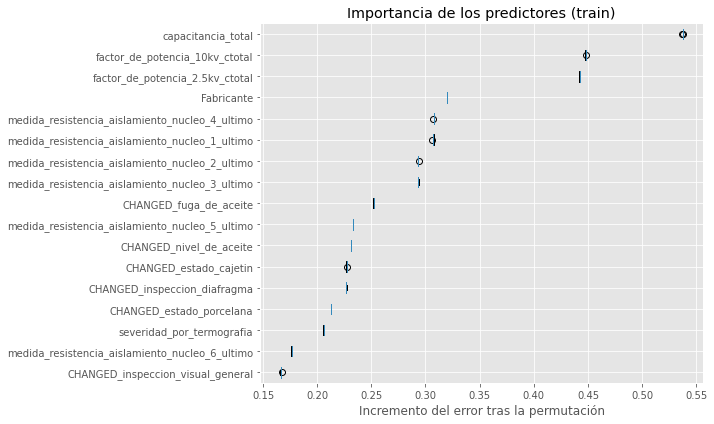

In [23]:
# Gráfico
fig, ax = plt.subplots(figsize=(10, 6))

sorted_idx = importancia.importances_mean.argsort()
ax.boxplot(
        importancia.importances[sorted_idx].T,
        vert   = False,
        labels =df_x_train_c2.columns[sorted_idx]
)
ax.set_title('Importancia de los predictores (train)')
ax.set_xlabel('Incremento del error tras la permutación')
fig.tight_layout();